# Store Sales Competetion


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Events
# Step 1: Load all required CSV files
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
transactions = pd.read_csv('transactions.csv')

# Step 2: Merge stores.csv (based on 'store_nbr')
train = train.merge(stores, on='store_nbr', how='left')

# Step 3: Merge oil.csv (based on 'date')
train = train.merge(oil[['date', 'dcoilwtico']], on='date', how='left')

# Step 4: Prepare and merge holidays_events.csv
# Create a flag column
holidays['holiday_flag'] = 1

# Optionally filter for only real holidays
# holidays = holidays[(holidays['type'] == 'Holiday') & (holidays['locale'] == 'National')]

# Merge with train
train = train.merge(holidays[['date', 'holiday_flag']], on='date', how='left')

# Step 5: Merge transactions.csv
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')

# Step 6: Fill missing values
# 6.1 Fill holiday_flag with 0 (non-holiday)
train['holiday_flag'] = train['holiday_flag'].fillna(0)

# 6.2 Fill transactions with 0 (assume no transaction info = no transactions)
train['transactions'] = train['transactions'].fillna(0)

# 6.3 Use Iterative Imputer for dcoilwtico (oil price)
def fill_oil_with_iterative_imputer(df):
    imputer = IterativeImputer(random_state=42)
    cols_for_imputation = ['dcoilwtico', 'transactions', 'sales', 'onpromotion']
    used_cols = [col for col in cols_for_imputation if col in df.columns]

    temp_df = df[used_cols]
    imputed_array = imputer.fit_transform(temp_df)

    df['dcoilwtico'] = imputed_array[:, used_cols.index('dcoilwtico')]
    return df

train = fill_oil_with_iterative_imputer(train)

# Final cleaned dataframe ready!
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_flag,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,71.012254,1.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,71.012254,1.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,71.012254,1.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,71.012254,1.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,71.012254,1.0,0.0


In [3]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_flag,transactions
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,1.0,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,1.0,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,1.0,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,1.0,2155.0
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,1.0,2155.0


In [4]:
print(f"Train data shape after merging {train.shape}")

Train data shape after merging (3054348, 13)


In [ ]:
test_df = pd.read_csv('test.csv')

In [6]:
print(f"Test data {test_df.shape}")

Test data (28512, 5)


In [7]:
train['date'] = pd.to_datetime(train['date'])

train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['weekday'] = train['date'].dt.weekday
train['is_weekend'] = train['weekday'].isin([5, 6]).astype(int)

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['family', 'city', 'state', 'type']:
    train[col] = le.fit_transform(train[col])

In [9]:
features = [
    'store_nbr', 'family', 'onpromotion', 'transactions',
    'dcoilwtico', 'holiday_flag', 'cluster', 'type',
    'day', 'month', 'year', 'weekday', 'is_weekend'
]

target = 'sales'

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Sort by date
train = train.sort_values('date')

# Set a cutoff date for validation — e.g., last 3 months of data for validation
cutoff_date = '2017-05-01'

# Time-based split
X_train = train[train['date'] < cutoff_date][features]
y_train = train[train['date'] < cutoff_date][target]

X_val = train[train['date'] >= cutoff_date][features]
y_val = train[train['date'] >= cutoff_date][target]


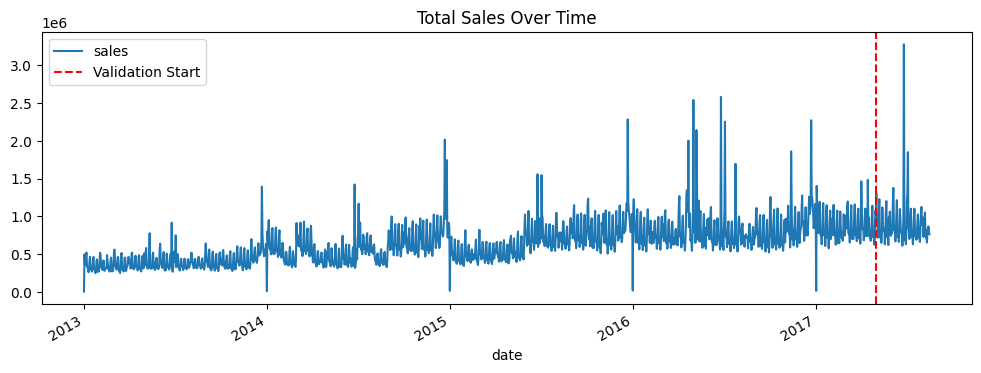

In [12]:
import matplotlib.pyplot as plt

train.groupby('date')['sales'].sum().plot(figsize=(12,4), title="Total Sales Over Time")
plt.axvline(pd.to_datetime(cutoff_date), color='red', linestyle='--', label='Validation Start')
plt.legend()
plt.show()


In [ ]:
# Step 1: Load the test set
test = pd.read_csv('test.csv')  # should contain ['id', 'date', 'store_nbr', 'family', 'onpromotion']

# Step 2: Merge with stores
test = test.merge(stores, on='store_nbr', how='left')

# Step 3: Merge with oil prices
test = test.merge(oil[['date', 'dcoilwtico']], on='date', how='left')

# Step 4: Merge with holidays
test = test.merge(holidays[['date', 'holiday_flag']], on='date', how='left')
test['holiday_flag'] = test['holiday_flag'].fillna(0)

# Step 5: Merge with transactions
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test['transactions'] = test['transactions'].fillna(0)


In [14]:
# Fill missing oil prices using IterativeImputer (same as training)
def fill_oil_with_iterative_imputer_test(df, train_ref):
    imputer = IterativeImputer(random_state=42)
    used_cols = ['dcoilwtico', 'transactions', 'onpromotion']

    # Use training data to fit imputer
    imputer.fit(train_ref[used_cols])

    imputed_array = imputer.transform(df[used_cols])
    df['dcoilwtico'] = imputed_array[:, used_cols.index('dcoilwtico')]
    return df

test = fill_oil_with_iterative_imputer_test(test, train)


In [15]:
test['date'] = pd.to_datetime(test['date'])
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['weekday'] = test['date'].dt.weekday
test['is_weekend'] = test['weekday'].isin([5, 6]).astype(int)


In [16]:
# Apply same label encoding (train should include all possible categories!)
for col in ['family', 'city', 'state', 'type']:
    test[col] = le.fit_transform(test[col])


# Models with optuna

In [17]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# -------------------------------
# Sample time-sorted data
# -------------------------------
train_sorted = train.sort_values("date")
train_sampled = train_sorted.iloc[:500_000]  # Adjust to 3_000_000 if needed

X_sample = train_sampled[features]
y_sample = train_sampled[target]

# -------------------------------
# RMSLE scorer
# -------------------------------
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# -------------------------------
# Optuna objective
# -------------------------------
def objective(trial):
    model_name = trial.suggest_categorical("model", ["xgb"])

    model_name == "xgb"
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'device': 'cuda'
        }
    model = XGBRegressor(**params, verbosity=0)

  
    # Time series cross-validation
    cv = TimeSeriesSplit(n_splits=3)
    score = cross_val_score(model, X_sample, y_sample, cv=cv, scoring=rmsle_scorer).mean()
    return score  # Negative RMSLE

# -------------------------------
# Run Optuna
# -------------------------------
study = optuna.create_study(direction='maximize')  # Because score is negative RMSLE
study.optimize(objective, n_trials=50)

# -------------------------------
# Best model and parameters
# -------------------------------
print("Best Trial:")
print(study.best_trial)

trial_params = study.best_trial.params.copy()
best_model_name = trial_params.pop("model")
best_params = trial_params

[I 2025-07-21 05:53:07,708] A new study created in memory with name: no-name-e14af1a8-7173-4ada-886a-bcad06d8b918
[I 2025-07-21 05:53:16,035] Trial 0 finished with value: -1.271986418418957 and parameters: {'model': 'xgb', 'n_estimators': 572, 'max_depth': 7, 'learning_rate': 0.1713446368057905, 'subsample': 0.6799561559063717, 'colsample_bytree': 0.8749231946386525, 'gamma': 1.2689496802608302, 'reg_alpha': 3.4683157625392056, 'reg_lambda': 1.527624018421746}. Best is trial 0 with value: -1.271986418418957.
[I 2025-07-21 05:53:54,982] Trial 1 finished with value: -1.0017795540688634 and parameters: {'model': 'xgb', 'n_estimators': 481, 'max_depth': 12, 'learning_rate': 0.11962748071419878, 'subsample': 0.8084216470502439, 'colsample_bytree': 0.913769479166713, 'gamma': 1.6399720953537726, 'reg_alpha': 1.2336759600980547, 'reg_lambda': 1.871422521721664}. Best is trial 1 with value: -1.0017795540688634.
[I 2025-07-21 05:54:04,403] Trial 2 finished with value: -1.3601164984197094 and pa

Best Trial:
FrozenTrial(number=42, state=1, values=[-0.882472161142899], datetime_start=datetime.datetime(2025, 7, 21, 6, 10, 0, 565118), datetime_complete=datetime.datetime(2025, 7, 21, 6, 10, 31, 675327), params={'model': 'xgb', 'n_estimators': 367, 'max_depth': 12, 'learning_rate': 0.03400696571982363, 'subsample': 0.8422714362282642, 'colsample_bytree': 0.9737978528696479, 'gamma': 4.519781602741839, 'reg_alpha': 0.444117894731094, 'reg_lambda': 0.347393512379682}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model': CategoricalDistribution(choices=('xgb',)), 'n_estimators': IntDistribution(high=1000, log=False, low=300, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'gamma': FloatDistribution(high=5.0

In [18]:
# -------------------------------
# Train best model on full training set
# -------------------------------
best_model_name == "xgb"
final_model = XGBRegressor(**best_params, verbosity=0, tree_method="hist", device="cuda")

final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9737978528696479, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=4.519781602741839,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03400696571982363,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=367, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# -------------------------------
# Validation RMSLE
# -------------------------------
y_val_pred = final_model.predict(X_val)
val_rmsle = rmsle(y_val, y_val_pred)
print(f"\nFinal Model: {best_model_name.upper()} | Validation RMSLE: {val_rmsle:.4f}")


Final Model: XGB | Validation RMSLE: 0.8078


In [ ]:
X_test = test[features]

# Predict with trained model
test_preds = final_model.predict(X_test)
test_preds = np.maximum(0, test_preds)  # Ensure no negative values

# Prepare submission
submission = pd.read_csv('sample_submission.csv')
submission['sales'] = test_preds

submission.to_csv('submission.csv', index=False)